In [2]:
"""700773514Home Assignment 2 .ipynb


Original file is located at
    https://colab.research.google.com/drive/1W3LC9W8l7F-ijwRmpBqoj4rer-wnre1c
"""

#Question 7 - Build a Desicion tree

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X, y = load_iris(return_X_y=True)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

for depth in [1, 2, 3]:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_tr, y_tr)
    tr_acc = accuracy_score(y_tr, clf.predict(X_tr))
    te_acc = accuracy_score(y_te, clf.predict(X_te))
    print(f"max_depth={depth}: train_acc={tr_acc:.3f}, test_acc={te_acc:.3f}")





max_depth=1: train_acc=0.667, test_acc=0.667
max_depth=2: train_acc=0.967, test_acc=0.933
max_depth=3: train_acc=0.983, test_acc=0.967


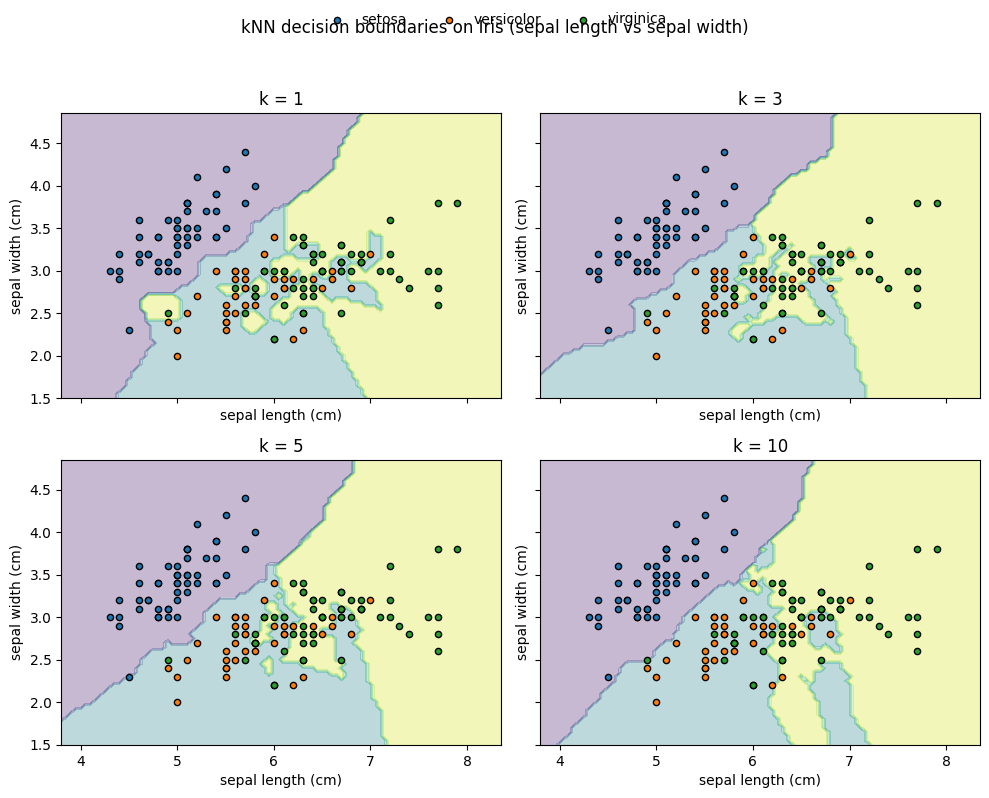

In [3]:
#Question 8 - kNN Classification (sklearn)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier

# 1) Load Iris; keep only sepal length (x0) & sepal width (x1)
iris = load_iris()
X = iris.data[:, :2]            # columns 0,1 = sepal length, sepal width
y = iris.target
names = iris.target_names

# 2) Train four KNN models
ks = [1, 3, 5, 10]
models = {k: KNeighborsClassifier(n_neighbors=k, metric="euclidean").fit(X, y) for k in ks}

# 3) Build a grid over feature space
h = 0.05
x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# 4) Plot decision boundaries
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
for ax, k in zip(axes.ravel(), ks):
    Z = models[k].predict(grid).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    # training points
    for cls in np.unique(y):
        pts = X[y==cls]
        ax.scatter(pts[:,0], pts[:,1], s=20, edgecolor="k", label=names[cls] if k==1 else None)
    ax.set_title(f"k = {k}")
    ax.set_xlabel("sepal length (cm)")
    ax.set_ylabel("sepal width (cm)")
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, frameon=False)
fig.suptitle("kNN decision boundaries on Iris (sepal length vs sepal width)")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



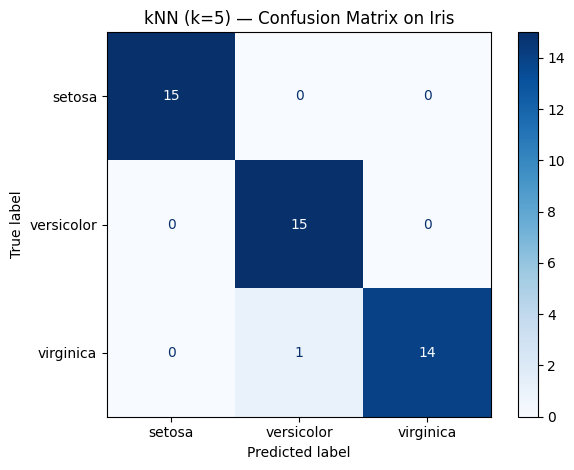

Classification report:
              precision    recall  f1-score   support

      setosa      1.000     1.000     1.000        15
  versicolor      0.938     1.000     0.968        15
   virginica      1.000     0.933     0.966        15

    accuracy                          0.978        45
   macro avg      0.979     0.978     0.978        45
weighted avg      0.979     0.978     0.978        45



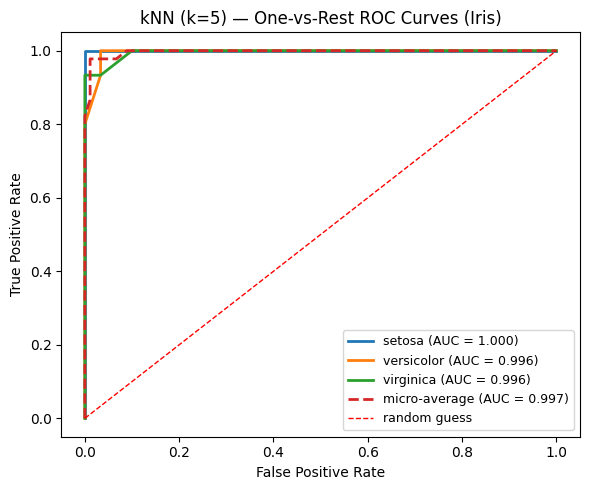

Macro-average AUC (ovr): 0.997


In [4]:
# Question 9 - Performance Evaluation Programming
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc, roc_auc_score
)
from sklearn.preprocessing import label_binarize

# 1) Data & split
X, y = load_iris(return_X_y=True)
class_names = load_iris().target_names
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 2) Train kNN (k=5)
clf = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
clf.fit(X_tr, y_tr)

# 3) Confusion matrix
y_pred = clf.predict(X_te)
cm = confusion_matrix(y_te, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("kNN (k=5) — Confusion Matrix on Iris")
plt.tight_layout()
plt.show()

# 4) Accuracy, precision, recall, F1 (per-class + macro/weighted)
print("Classification report:")
print(classification_report(y_te, y_pred, target_names=class_names, digits=3))

# 5) ROC curves (one-vs-rest) + AUC
#    For multiclass ROC: binarize labels and use predict_proba
y_test_bin = label_binarize(y_te, classes=np.unique(y))
proba = clf.predict_proba(X_te)  # shape: [n_samples, n_classes]

fpr, tpr, roc_auc = {}, {}, {}
for i, cname in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average AUC (quick way)
macro_auc = roc_auc_score(y_te, proba, multi_class="ovr", average="macro")

# Plot
plt.figure(figsize=(6, 5))
for i, cname in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{cname} (AUC = {roc_auc[i]:.3f})")
plt.plot(fpr["micro"], tpr["micro"], lw=2, linestyle="--", label=f"micro-average (AUC = {roc_auc['micro']:.3f})")
plt.plot([0, 1], [0, 1], "r--", lw=1, label="random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("kNN (k=5) — One-vs-Rest ROC Curves (Iris)")
plt.legend(loc="lower right", fontsize=9)
plt.tight_layout()
plt.show()

print(f"Macro-average AUC (ovr): {macro_auc:.3f}")